# 13.2c: Angular Distinguishability from Hero Token

**When do tokens become directionally distinguishable?**

At step 0, all tokens are nearly identical—they share the same direction in 64D space (cosine similarity ≈ 1.0). As training progresses, gradients nudge tokens off the BF16 lattice, and they become **angularly distinguishable** from our hero token '&' (token 38).

**This notebook tracks:**
1. For each token, **when** it first becomes distinguishable (`cos_sim < 1.0` in BF16)
2. **How fast** cosine similarity decays after the initial break
3. **Dead vs live** token behavior—do dead tokens stay directionally frozen?

**Why cosine similarity?**
- Immune to magnitude drift (L2 distance can grow even if direction is constant)
- BF16 quantization creates discrete "pop" events when direction changes
- Reveals whether the dead core stays aligned (same direction) despite radial expansion

## Parameters

In [1]:
# Data sources (we'll analyze both SGD and Adam)
SGD_DATA_PATH = "../tensors/Lil_Gatsby/13.1a_training_data.safetensors"
ADAM_DATA_PATH = "../tensors/Lil_Gatsby/13.1b_training_data.safetensors"

# Hero token
HERO_TOKEN_ID = 38  # '&' character, confirmed dead

# Distinguishability threshold
# We use a slightly relaxed threshold to account for BF16 rounding noise
COSINE_THRESHOLD = 0.9999  # Tokens with cos_sim < this are "distinguishable"

# Visualization
DPI = 200
COLORMAP = 'inferno'

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import safe_open
from tqdm.auto import tqdm

np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
def load_training_data(path):
    """Load embeddings and metadata from safetensors."""
    print(f"Loading: {path}")
    with safe_open(path, framework='pt', device='cpu') as f:
        embeddings_bf16 = f.get_tensor('embeddings')
        dead_token_ids = f.get_tensor('dead_token_ids')
        live_token_ids = f.get_tensor('live_token_ids')
        recorded_steps = f.get_tensor('recorded_steps')
    
    # Keep in BF16 for now (we'll convert explicitly when needed)
    print(f"  Embeddings: {embeddings_bf16.shape}")
    print(f"  Steps: {recorded_steps[0]} to {recorded_steps[-1]}")
    print(f"  Dead tokens: {len(dead_token_ids)}, Live tokens: {len(live_token_ids)}")
    
    return embeddings_bf16, dead_token_ids, live_token_ids, recorded_steps

# Load both datasets
print("=" * 80)
print("SGD (13.1a)")
print("=" * 80)
sgd_emb, sgd_dead, sgd_live, sgd_steps = load_training_data(SGD_DATA_PATH)

print("\n" + "=" * 80)
print("Adam (13.1b)")
print("=" * 80)
adam_emb, adam_dead, adam_live, adam_steps = load_training_data(ADAM_DATA_PATH)

print("\n✓ Data loaded")

# Verify hero token is dead
is_dead_sgd = HERO_TOKEN_ID in sgd_dead
is_dead_adam = HERO_TOKEN_ID in adam_dead
print(f"\nHero token {HERO_TOKEN_ID} ('&') is DEAD in SGD: {is_dead_sgd}")
print(f"Hero token {HERO_TOKEN_ID} ('&') is DEAD in Adam: {is_dead_adam}")

SGD (13.1a)
Loading: ../tensors/Lil_Gatsby/13.1a_training_data.safetensors
  Embeddings: torch.Size([10001, 128, 64])
  Steps: 0 to 10000
  Dead tokens: 50, Live tokens: 78

Adam (13.1b)
Loading: ../tensors/Lil_Gatsby/13.1b_training_data.safetensors
  Embeddings: torch.Size([10001, 128, 64])
  Steps: 0 to 10000
  Dead tokens: 50, Live tokens: 78

✓ Data loaded

Hero token 38 ('&') is DEAD in SGD: True
Hero token 38 ('&') is DEAD in Adam: True


## Compute Cosine Similarity Evolution

In [5]:
def compute_cosine_similarity_to_hero(embeddings_bf16, hero_id, device):
    """
    Compute cosine similarity from hero token to all others at every step.
    
    Keep computation in BF16 to preserve quantization effects.
    
    Returns:
        cos_sim: [n_steps, n_tokens] cosine similarity matrix
    """
    n_steps, n_tokens, n_dims = embeddings_bf16.shape
    
    # Convert to float32 for stable computation, then back to BF16
    # (PyTorch doesn't support all ops in BF16, especially on CPU/MPS)
    embeddings_f32 = embeddings_bf16.to(torch.float32).to(device)
    
    cos_sim_all = []
    
    for step_idx in tqdm(range(n_steps), desc="Computing cosine similarities"):
        emb = embeddings_f32[step_idx]  # [n_tokens, n_dims]
        
        # Hero token vector
        hero_vec = emb[hero_id]  # [n_dims]
        
        # Normalize both
        hero_norm = hero_vec / hero_vec.norm(p=2)
        emb_norm = emb / emb.norm(p=2, dim=1, keepdim=True)
        
        # Cosine similarity = dot product of normalized vectors
        cos_sim = (emb_norm @ hero_norm).cpu()  # [n_tokens]
        
        # Convert to BF16 to match training precision
        cos_sim_bf16 = cos_sim.to(torch.bfloat16).to(torch.float32)  # BF16 round-trip
        
        cos_sim_all.append(cos_sim_bf16)
    
    cos_sim_tensor = torch.stack(cos_sim_all, dim=0)  # [n_steps, n_tokens]
    
    return cos_sim_tensor

print("Computing cosine similarities for SGD...")
sgd_cos_sim = compute_cosine_similarity_to_hero(sgd_emb, HERO_TOKEN_ID, device)

print("\nComputing cosine similarities for Adam...")
adam_cos_sim = compute_cosine_similarity_to_hero(adam_emb, HERO_TOKEN_ID, device)

print("\n✓ Cosine similarities computed")

Computing cosine similarities for SGD...


Computing cosine similarities:   0%|          | 0/10001 [00:00<?, ?it/s]


Computing cosine similarities for Adam...


Computing cosine similarities:   0%|          | 0/10001 [00:00<?, ?it/s]


✓ Cosine similarities computed


## Find "Birth" Step for Each Token

In [6]:
def find_birth_steps(cos_sim, threshold, hero_id):
    """
    For each token, find the first step where cos_sim < threshold.
    
    Returns:
        birth_steps: [n_tokens] array, step number or -1 if never distinguished
    """
    n_steps, n_tokens = cos_sim.shape
    birth_steps = np.full(n_tokens, -1, dtype=int)  # -1 = never distinguished
    
    # Hero token always has cos_sim = 1.0 with itself, skip it
    for token_id in range(n_tokens):
        if token_id == hero_id:
            continue
        
        # Find first step where cos_sim < threshold
        distinguishable = cos_sim[:, token_id] < threshold
        if distinguishable.any():
            birth_steps[token_id] = distinguishable.nonzero()[0].item()
    
    return birth_steps

print(f"Finding birth steps (threshold = {COSINE_THRESHOLD})...\n")

sgd_births = find_birth_steps(sgd_cos_sim, COSINE_THRESHOLD, HERO_TOKEN_ID)
adam_births = find_birth_steps(adam_cos_sim, COSINE_THRESHOLD, HERO_TOKEN_ID)

# Statistics
def print_birth_stats(births, dead_ids, live_ids, name):
    dead_births = births[dead_ids.numpy()]
    live_births = births[live_ids.numpy()]
    
    dead_distinguished = (dead_births >= 0).sum()
    live_distinguished = (live_births >= 0).sum()
    
    print(f"{name}:")
    print(f"  Dead tokens distinguished: {dead_distinguished}/{len(dead_ids)}")
    print(f"  Live tokens distinguished: {live_distinguished}/{len(live_ids)}")
    
    if dead_distinguished > 0:
        dead_births_valid = dead_births[dead_births >= 0]
        print(f"  Dead birth steps: min={dead_births_valid.min()}, "
              f"median={np.median(dead_births_valid):.0f}, max={dead_births_valid.max()}")
    
    if live_distinguished > 0:
        live_births_valid = live_births[live_births >= 0]
        print(f"  Live birth steps: min={live_births_valid.min()}, "
              f"median={np.median(live_births_valid):.0f}, max={live_births_valid.max()}")
    print()

print_birth_stats(sgd_births, sgd_dead, sgd_live, "SGD")
print_birth_stats(adam_births, adam_dead, adam_live, "Adam")

print("✓ Birth steps computed")

Finding birth steps (threshold = 0.9999)...

SGD:
  Dead tokens distinguished: 0/50
  Live tokens distinguished: 49/78
  Live birth steps: min=46, median=522, max=3541

Adam:
  Dead tokens distinguished: 0/50
  Live tokens distinguished: 77/78
  Live birth steps: min=8, median=49, max=4382

✓ Birth steps computed


## Visualizations

### Birth Step Histograms: Dead vs Live

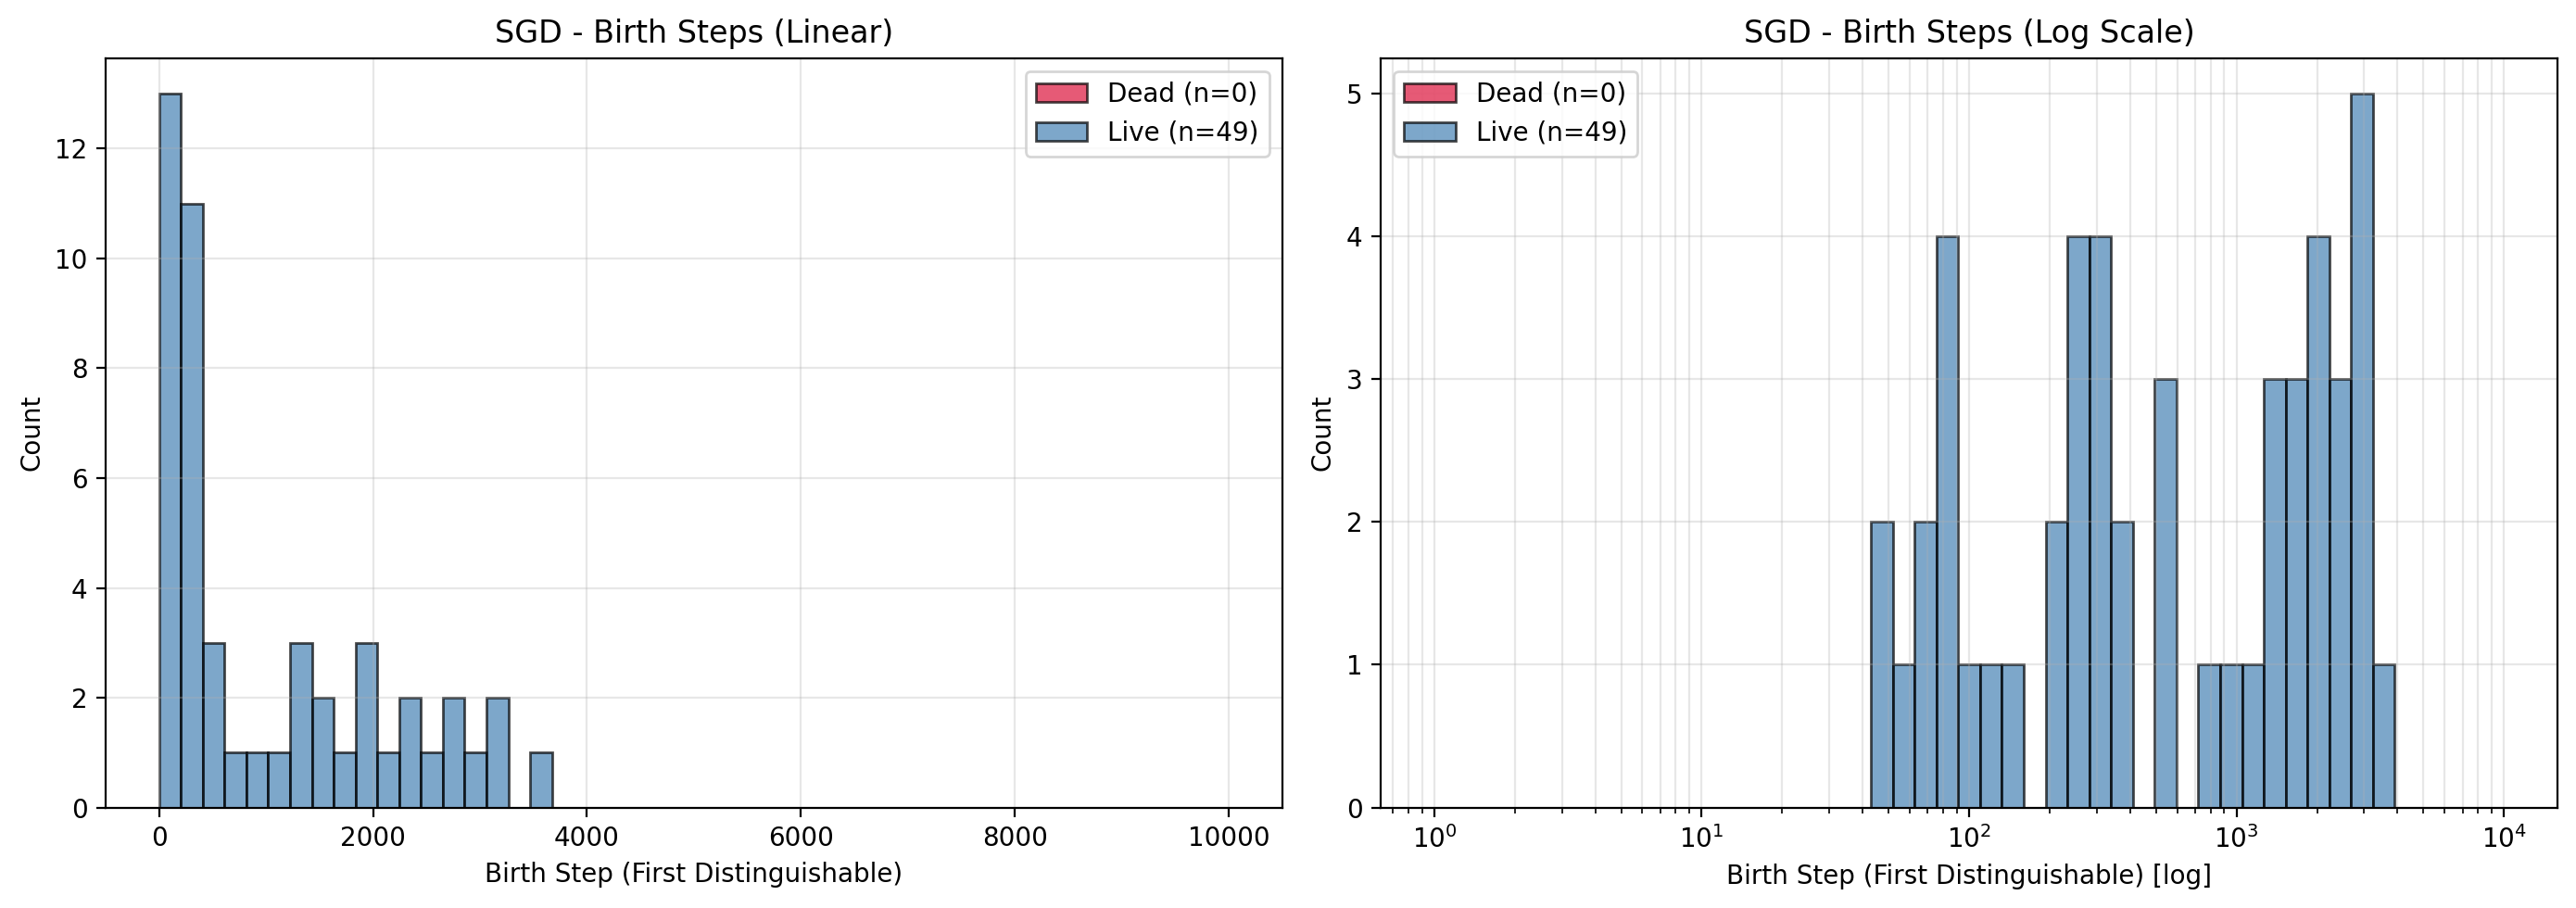

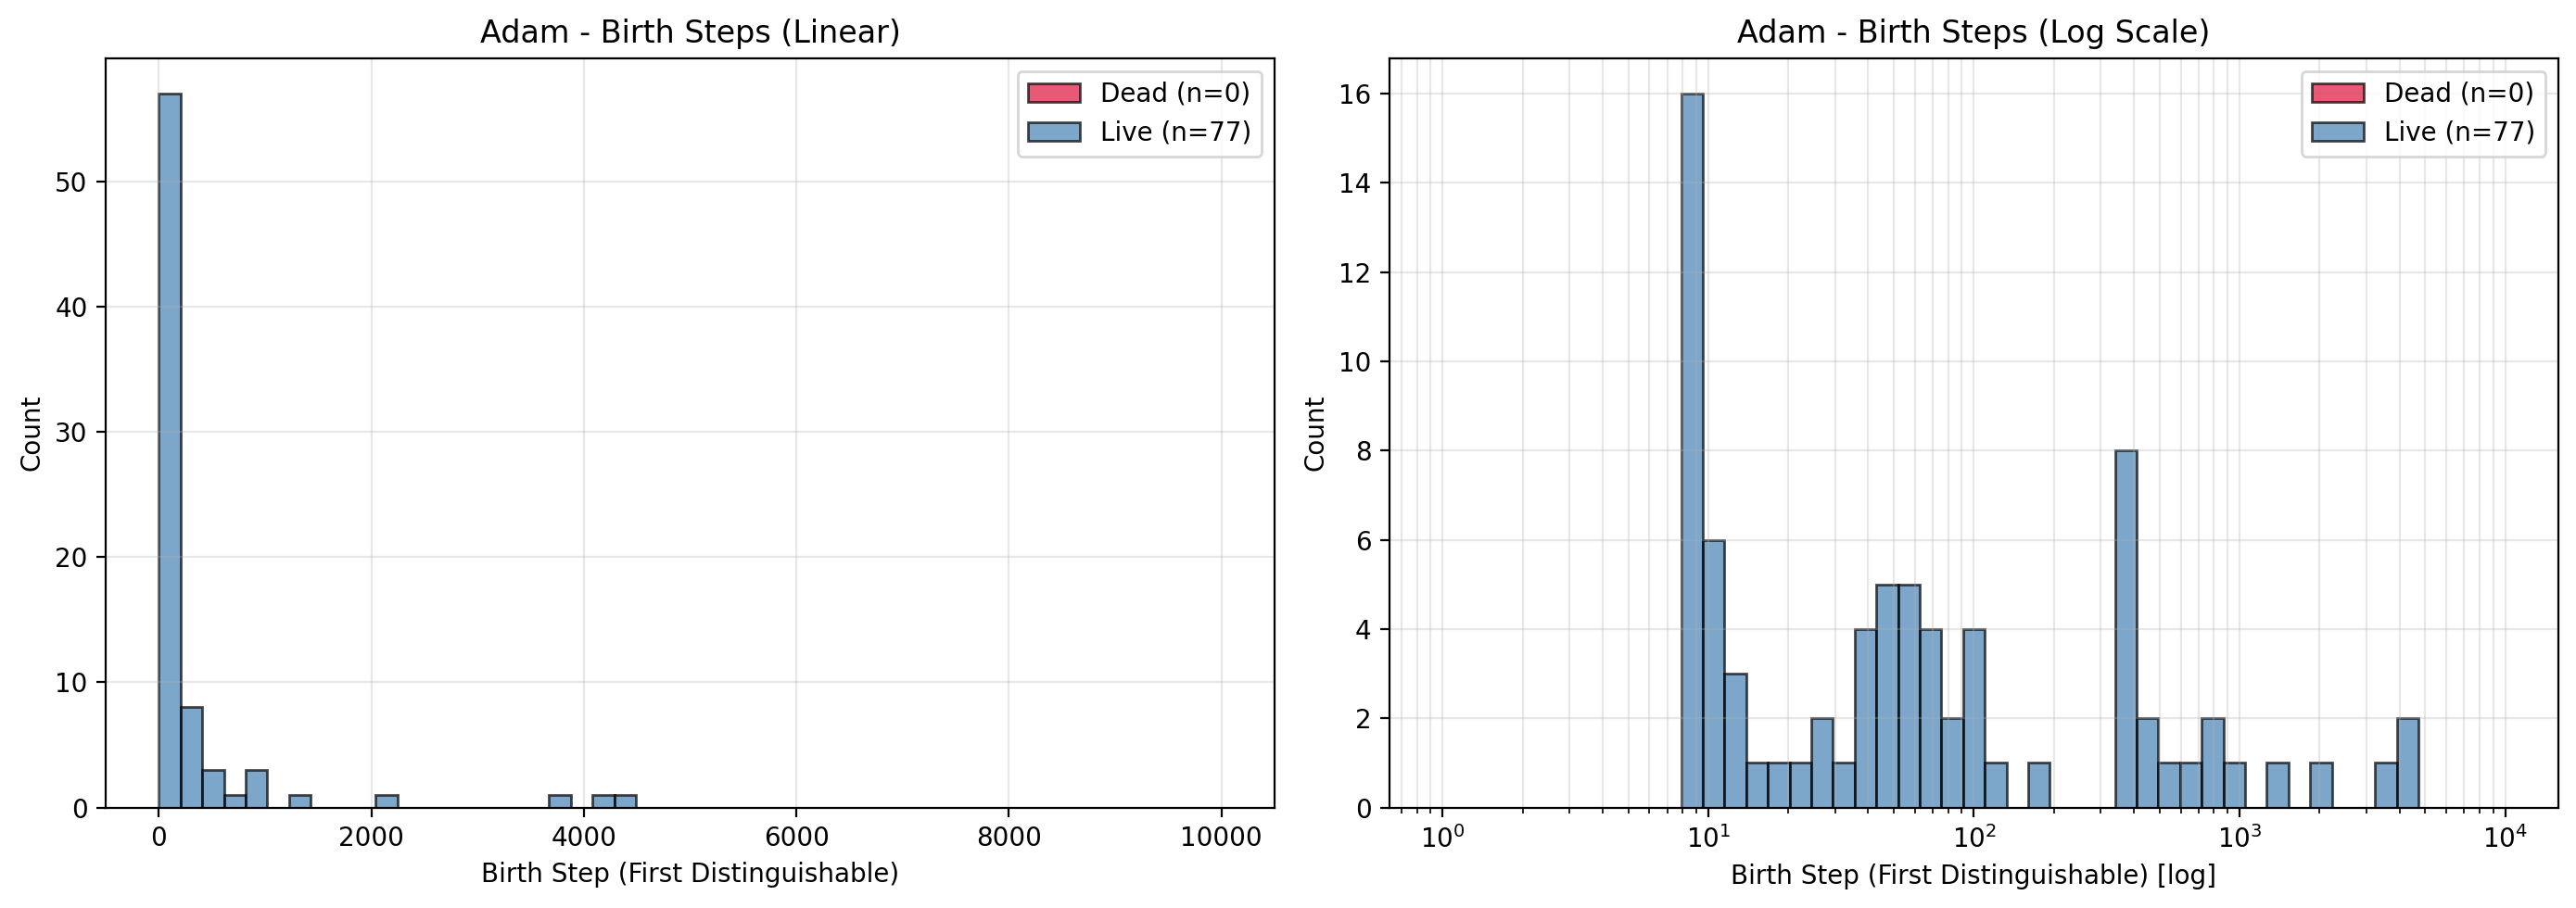

In [7]:
def plot_birth_histograms(births, dead_ids, live_ids, max_step, title):
    """
    Plot histograms of birth steps for dead vs live tokens.
    """
    dead_births = births[dead_ids.numpy()]
    live_births = births[live_ids.numpy()]
    
    # Filter out tokens that never distinguished (-1)
    dead_births_valid = dead_births[dead_births >= 0]
    live_births_valid = live_births[live_births >= 0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)
    
    # Linear scale
    bins_linear = np.linspace(0, max_step, 50)
    ax1.hist(dead_births_valid, bins=bins_linear, alpha=0.7, color='crimson', 
             label=f'Dead (n={len(dead_births_valid)})', edgecolor='black')
    ax1.hist(live_births_valid, bins=bins_linear, alpha=0.7, color='steelblue', 
             label=f'Live (n={len(live_births_valid)})', edgecolor='black')
    ax1.set_xlabel('Birth Step (First Distinguishable)')
    ax1.set_ylabel('Count')
    ax1.set_title(f'{title} - Birth Steps (Linear)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Log scale (x-axis)
    bins_log = np.logspace(0, np.log10(max_step + 1), 50)
    ax2.hist(dead_births_valid, bins=bins_log, alpha=0.7, color='crimson', 
             label=f'Dead (n={len(dead_births_valid)})', edgecolor='black')
    ax2.hist(live_births_valid, bins=bins_log, alpha=0.7, color='steelblue', 
             label=f'Live (n={len(live_births_valid)})', edgecolor='black')
    ax2.set_xlabel('Birth Step (First Distinguishable) [log]')
    ax2.set_ylabel('Count')
    ax2.set_title(f'{title} - Birth Steps (Log Scale)')
    ax2.set_xscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()

# SGD
plot_birth_histograms(sgd_births, sgd_dead, sgd_live, 
                     sgd_steps[-1].item(), "SGD")

# Adam
plot_birth_histograms(adam_births, adam_dead, adam_live, 
                     adam_steps[-1].item(), "Adam")

### Cosine Similarity Decay: Sample Tokens

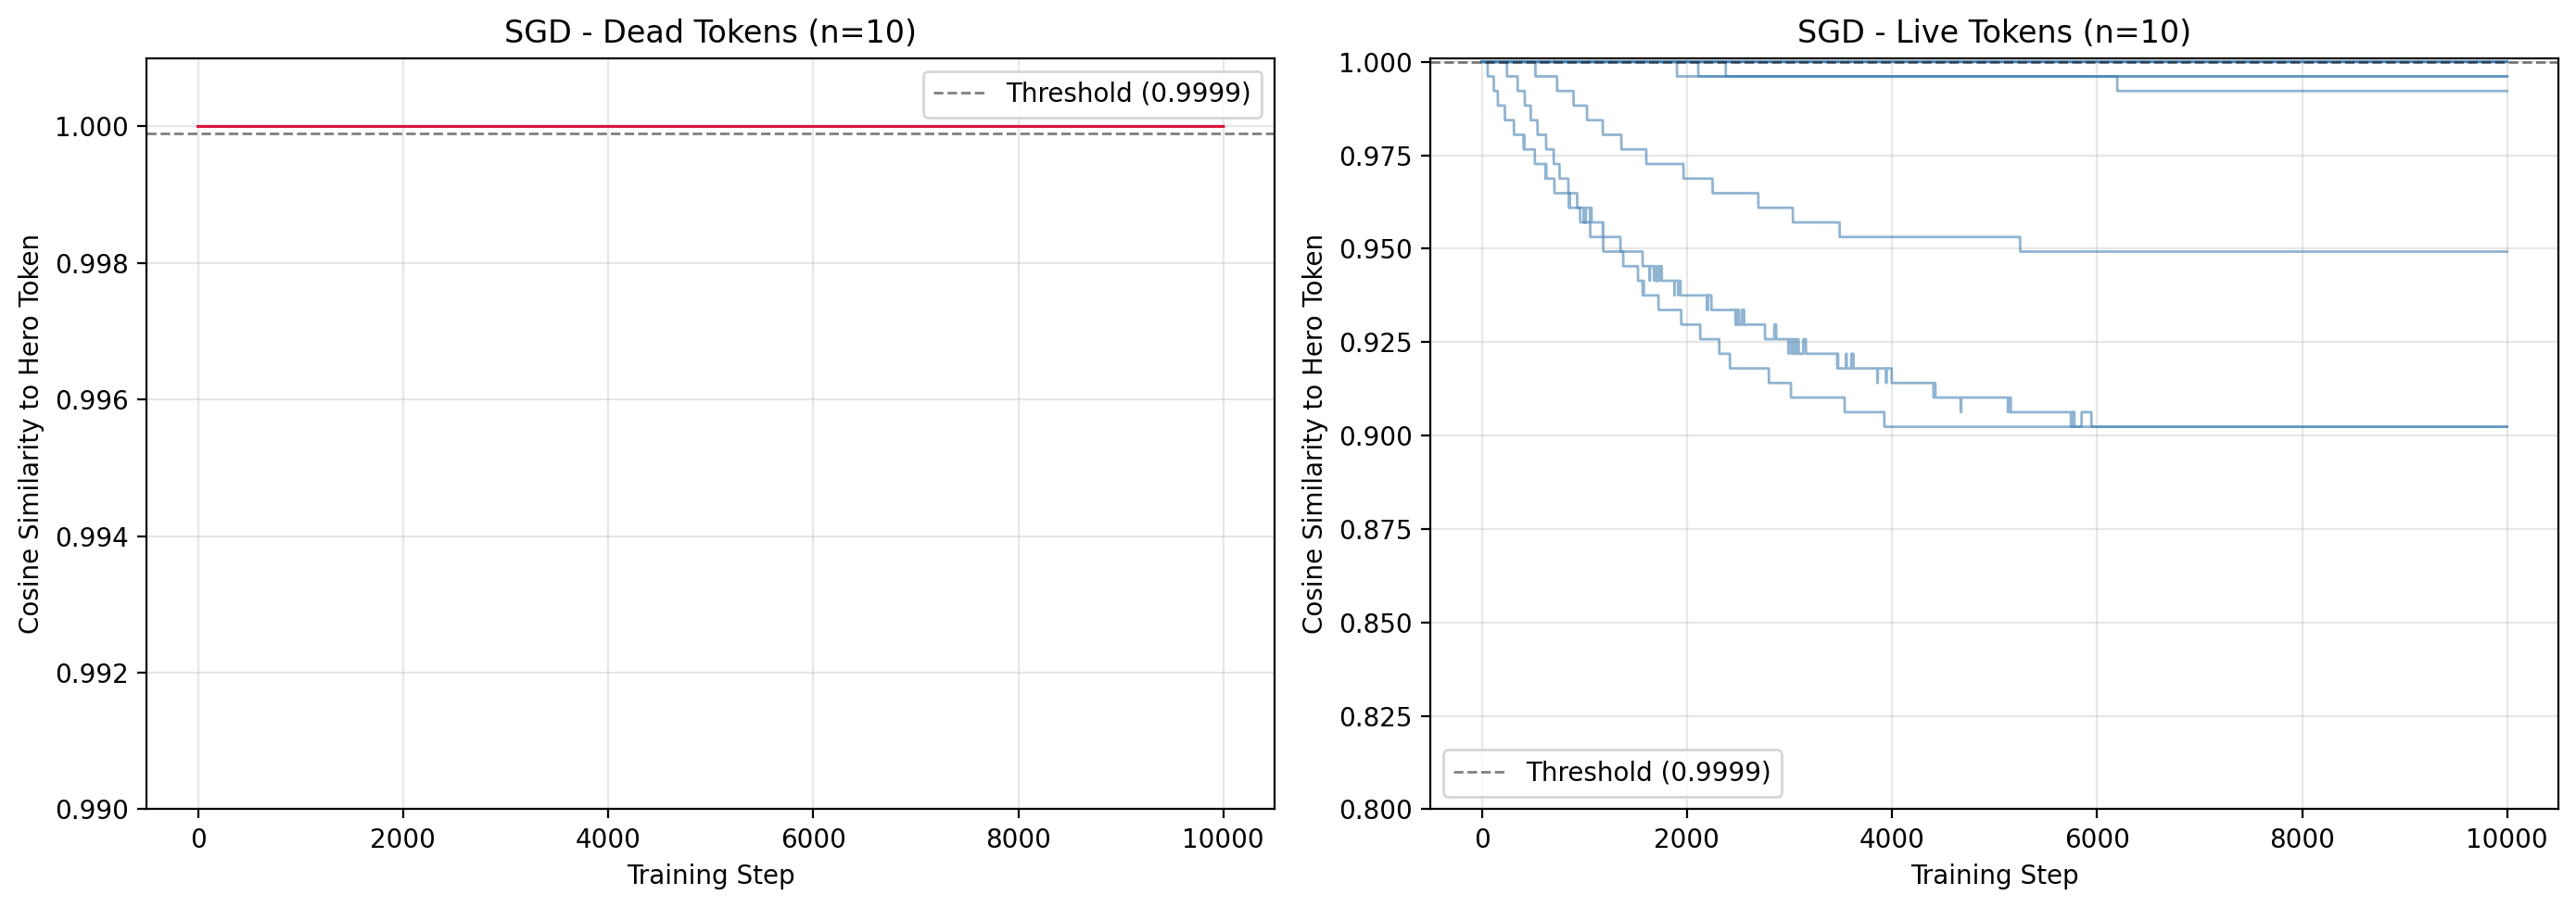

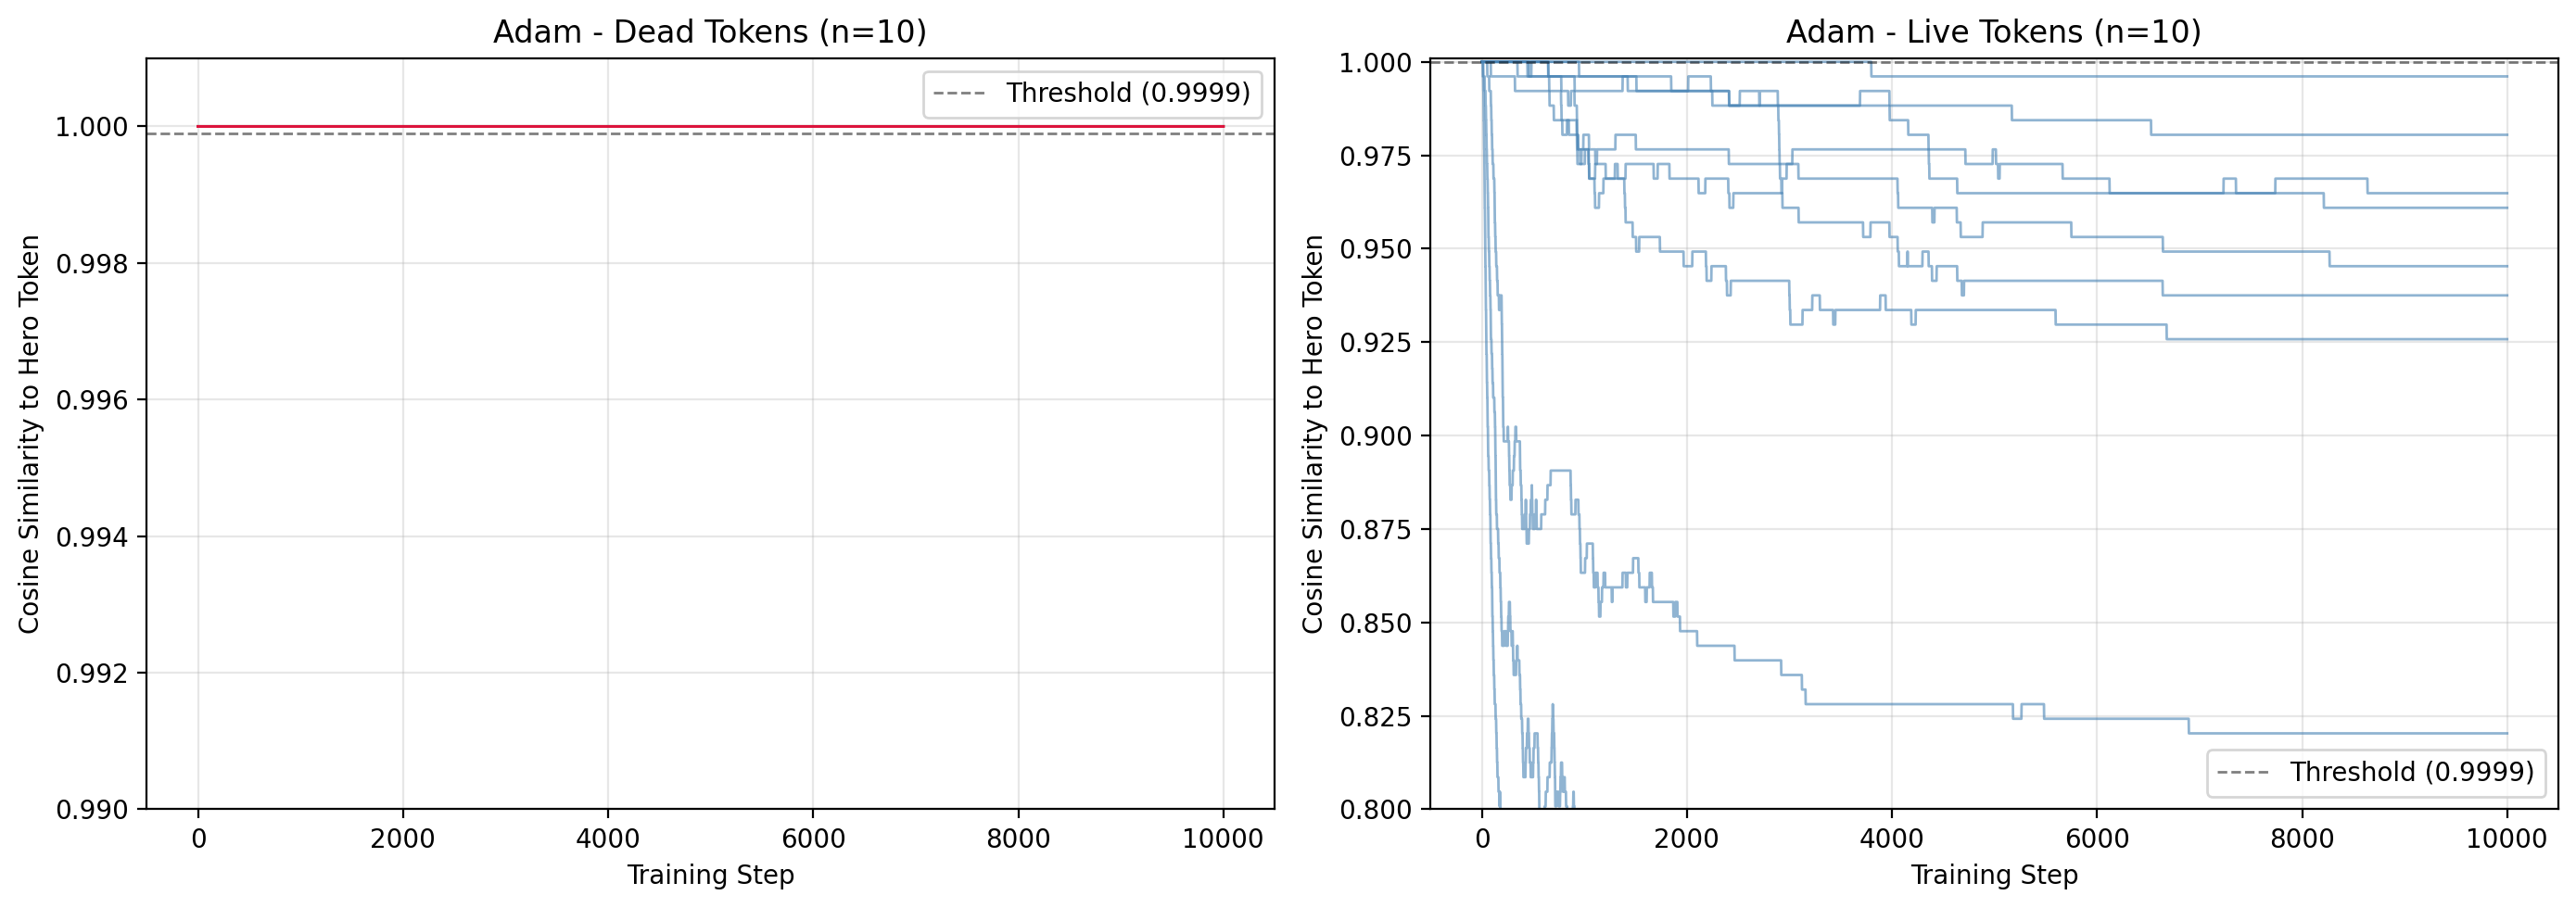

In [8]:
def plot_cosine_decay(cos_sim, dead_ids, live_ids, steps, title, n_samples=10):
    """
    Plot cosine similarity vs step for sample dead and live tokens.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)
    
    # Sample tokens
    dead_sample = np.random.choice(dead_ids.numpy(), size=min(n_samples, len(dead_ids)), replace=False)
    live_sample = np.random.choice(live_ids.numpy(), size=min(n_samples, len(live_ids)), replace=False)
    
    # Dead tokens
    for token_id in dead_sample:
        ax1.plot(steps.numpy(), cos_sim[:, token_id].numpy(), 
                linewidth=1, alpha=0.6, color='crimson')
    ax1.set_xlabel('Training Step')
    ax1.set_ylabel('Cosine Similarity to Hero Token')
    ax1.set_title(f'{title} - Dead Tokens (n={n_samples})')
    ax1.axhline(COSINE_THRESHOLD, color='black', linestyle='--', 
               linewidth=1, alpha=0.5, label=f'Threshold ({COSINE_THRESHOLD})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0.99, 1.001])  # Zoom in on the action
    
    # Live tokens
    for token_id in live_sample:
        ax2.plot(steps.numpy(), cos_sim[:, token_id].numpy(), 
                linewidth=1, alpha=0.6, color='steelblue')
    ax2.set_xlabel('Training Step')
    ax2.set_ylabel('Cosine Similarity to Hero Token')
    ax2.set_title(f'{title} - Live Tokens (n={n_samples})')
    ax2.axhline(COSINE_THRESHOLD, color='black', linestyle='--', 
               linewidth=1, alpha=0.5, label=f'Threshold ({COSINE_THRESHOLD})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0.8, 1.001])  # Wider range for live tokens
    
    plt.tight_layout()
    plt.show()

np.random.seed(RANDOM_SEED)  # Reproducible sampling

# SGD
plot_cosine_decay(sgd_cos_sim, sgd_dead, sgd_live, sgd_steps, "SGD")

# Adam
plot_cosine_decay(adam_cos_sim, adam_dead, adam_live, adam_steps, "Adam")

### Cumulative Distinguished Tokens Over Time

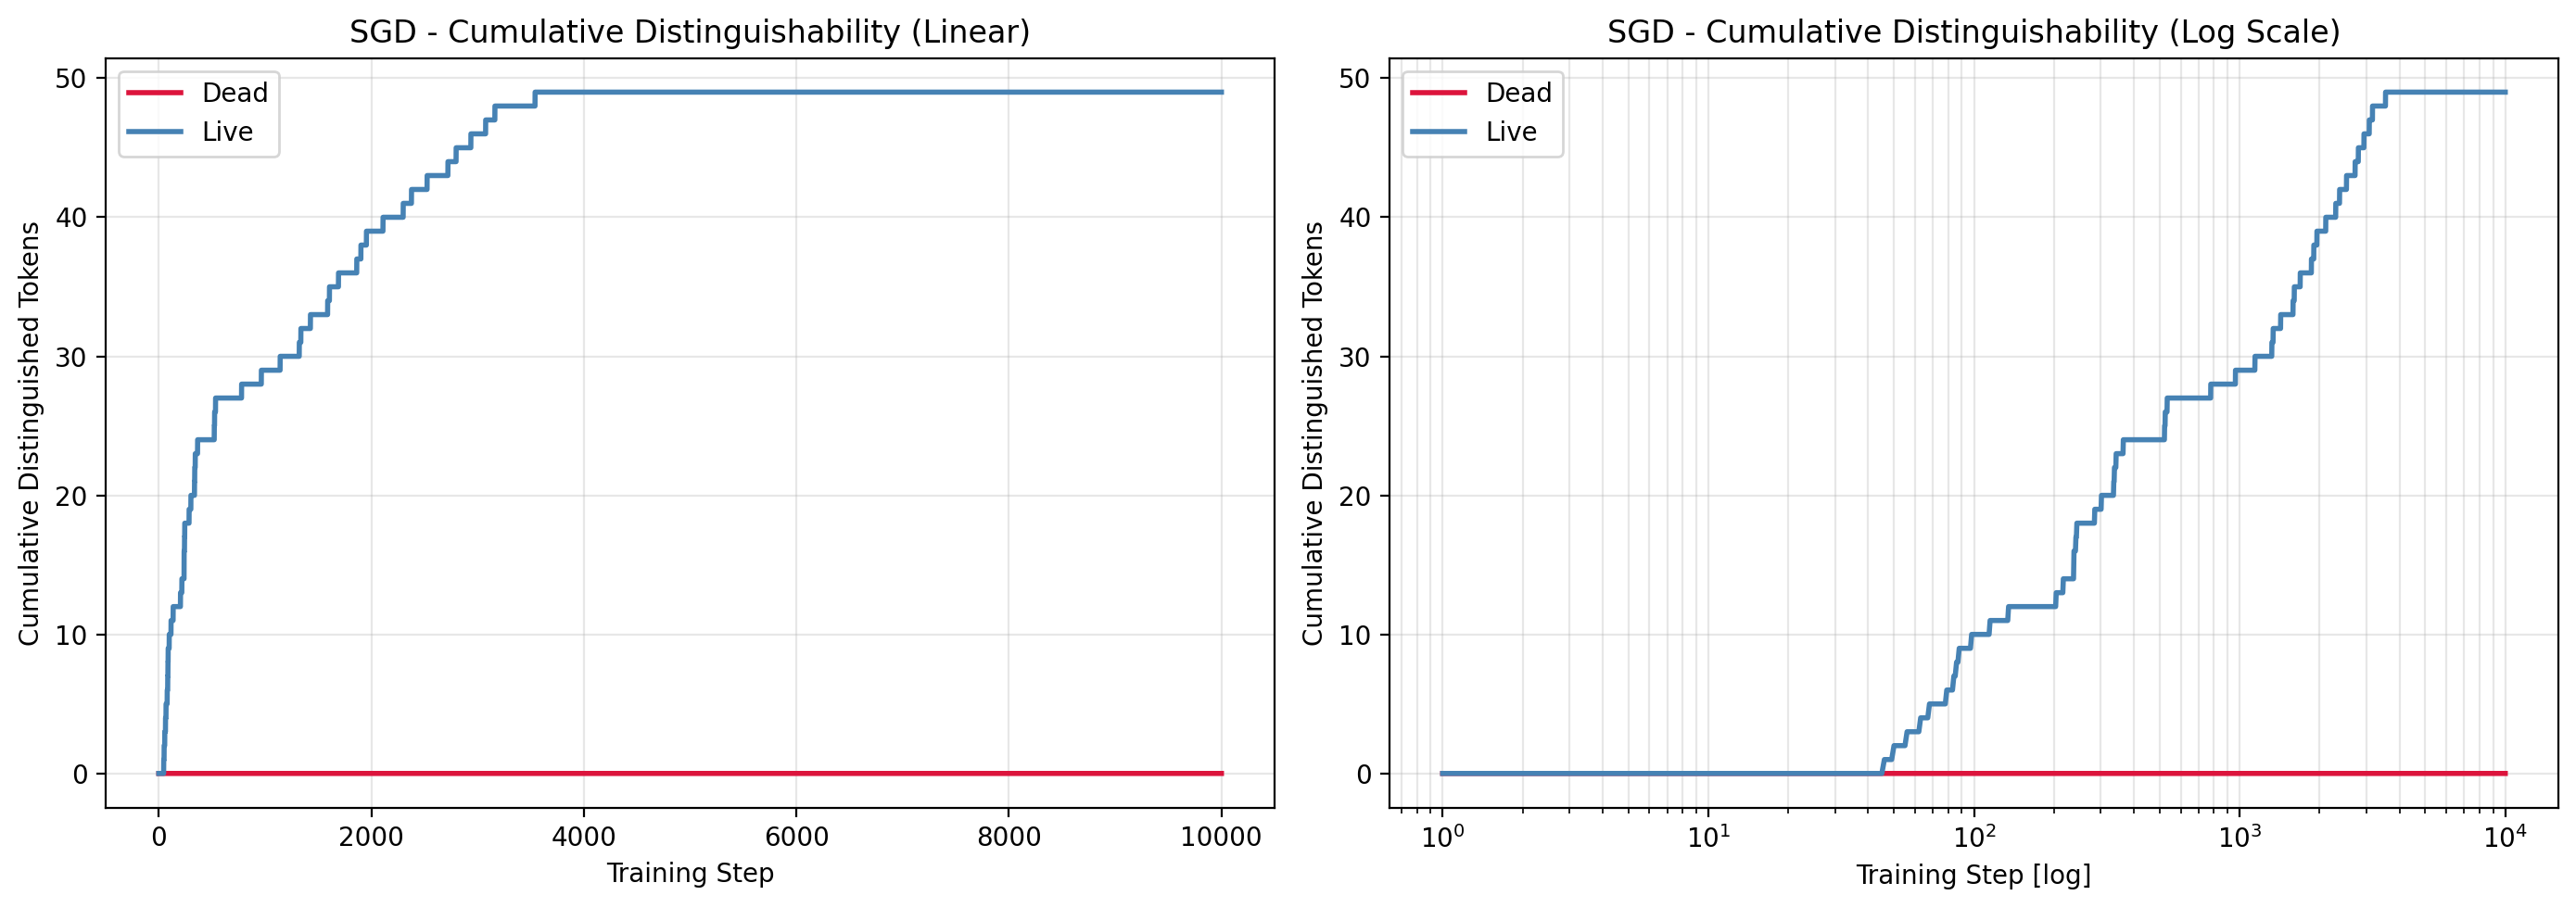

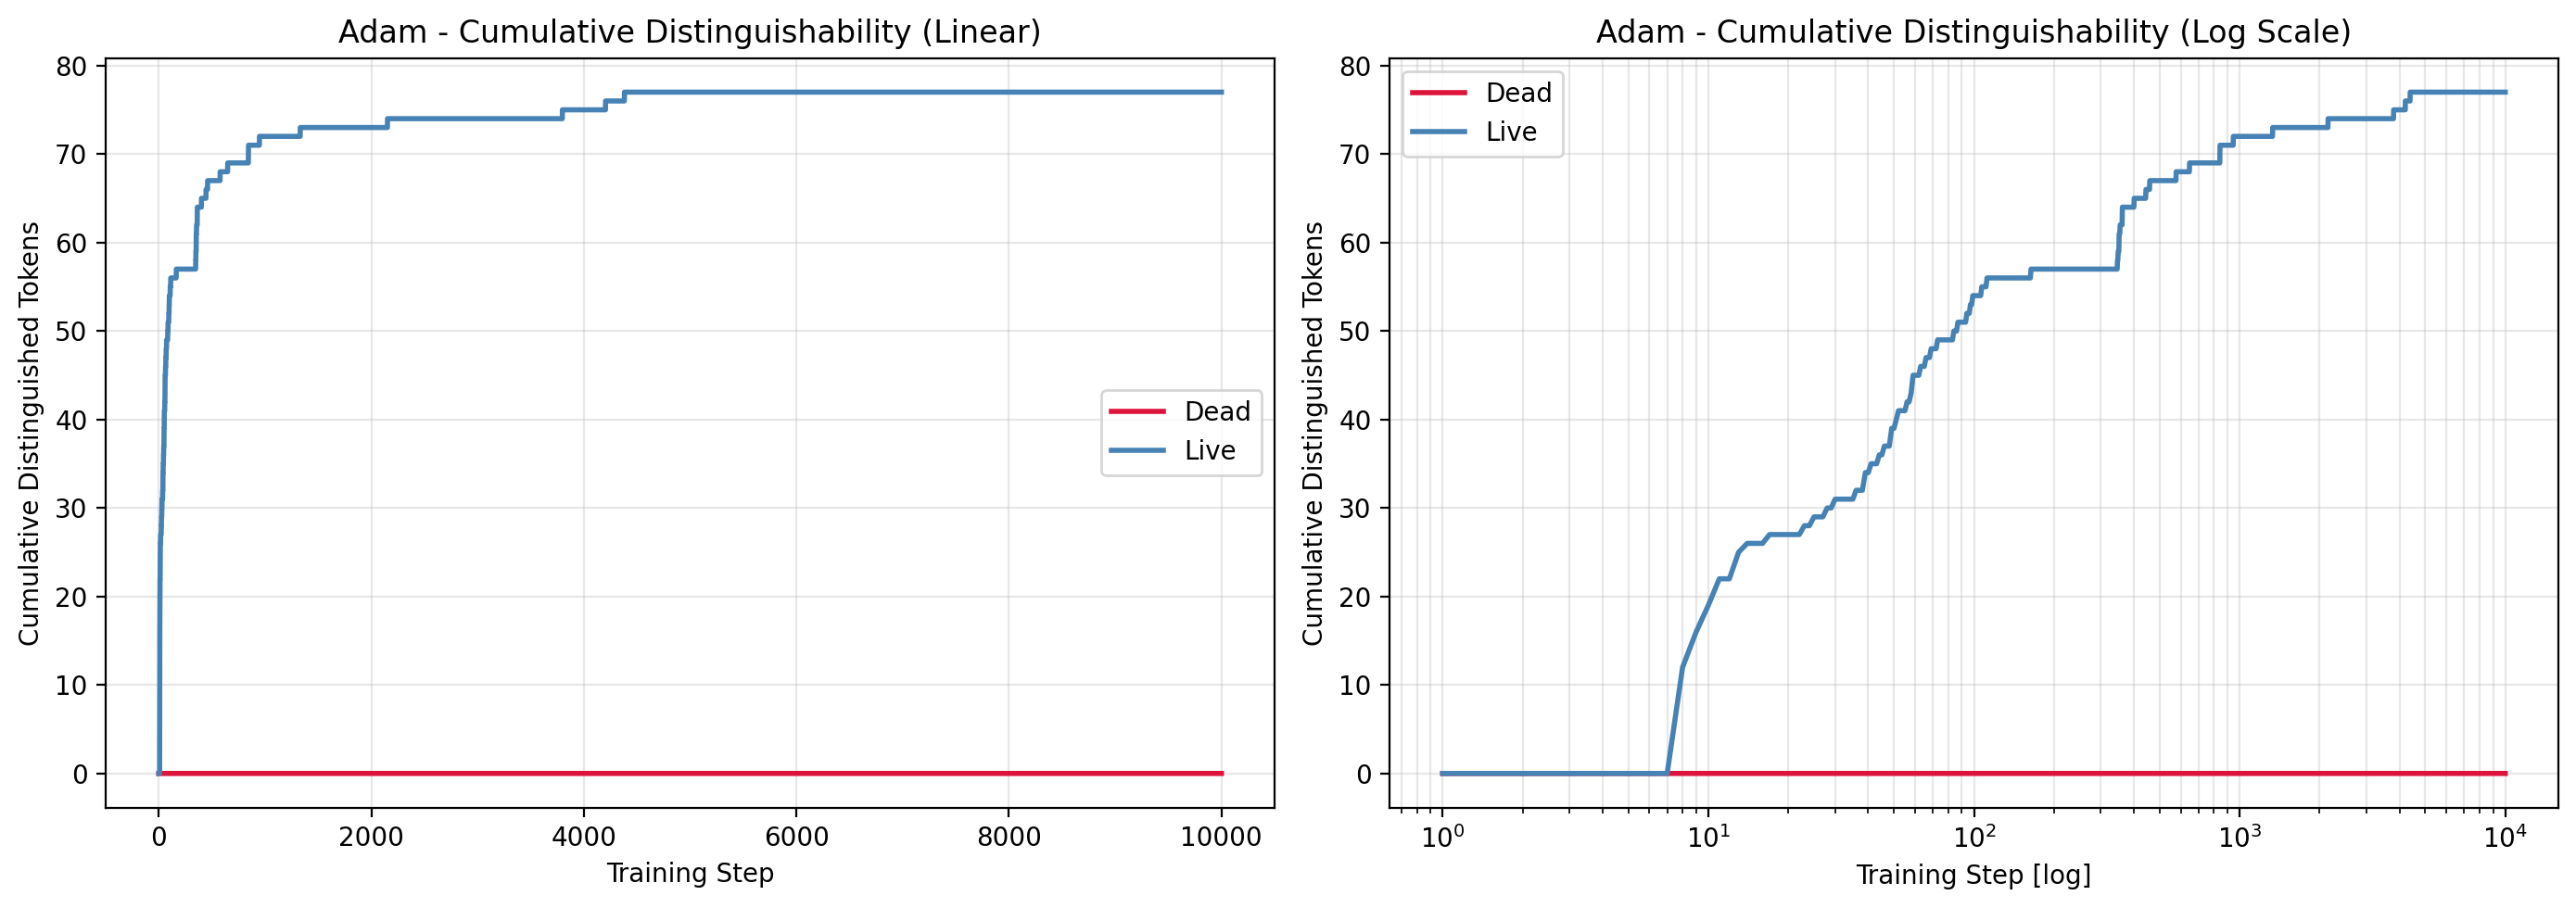

In [9]:
def plot_cumulative_distinguished(births, dead_ids, live_ids, max_step, title):
    """
    Plot cumulative count of distinguished tokens over time.
    """
    dead_births = births[dead_ids.numpy()]
    live_births = births[live_ids.numpy()]
    
    # Filter valid births
    dead_births_valid = dead_births[dead_births >= 0]
    live_births_valid = live_births[live_births >= 0]
    
    # Compute cumulative counts
    steps_range = np.arange(0, max_step + 1)
    dead_cumulative = np.array([np.sum(dead_births_valid <= s) for s in steps_range])
    live_cumulative = np.array([np.sum(live_births_valid <= s) for s in steps_range])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)
    
    # Linear scale
    ax1.plot(steps_range, dead_cumulative, linewidth=2, color='crimson', label='Dead')
    ax1.plot(steps_range, live_cumulative, linewidth=2, color='steelblue', label='Live')
    ax1.set_xlabel('Training Step')
    ax1.set_ylabel('Cumulative Distinguished Tokens')
    ax1.set_title(f'{title} - Cumulative Distinguishability (Linear)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Log scale (x-axis)
    ax2.plot(steps_range[1:], dead_cumulative[1:], linewidth=2, color='crimson', label='Dead')
    ax2.plot(steps_range[1:], live_cumulative[1:], linewidth=2, color='steelblue', label='Live')
    ax2.set_xlabel('Training Step [log]')
    ax2.set_ylabel('Cumulative Distinguished Tokens')
    ax2.set_title(f'{title} - Cumulative Distinguishability (Log Scale)')
    ax2.set_xscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()

# SGD
plot_cumulative_distinguished(sgd_births, sgd_dead, sgd_live, 
                             sgd_steps[-1].item(), "SGD")

# Adam
plot_cumulative_distinguished(adam_births, adam_dead, adam_live, 
                             adam_steps[-1].item(), "Adam")

### Comparison: SGD vs Adam Birth Times

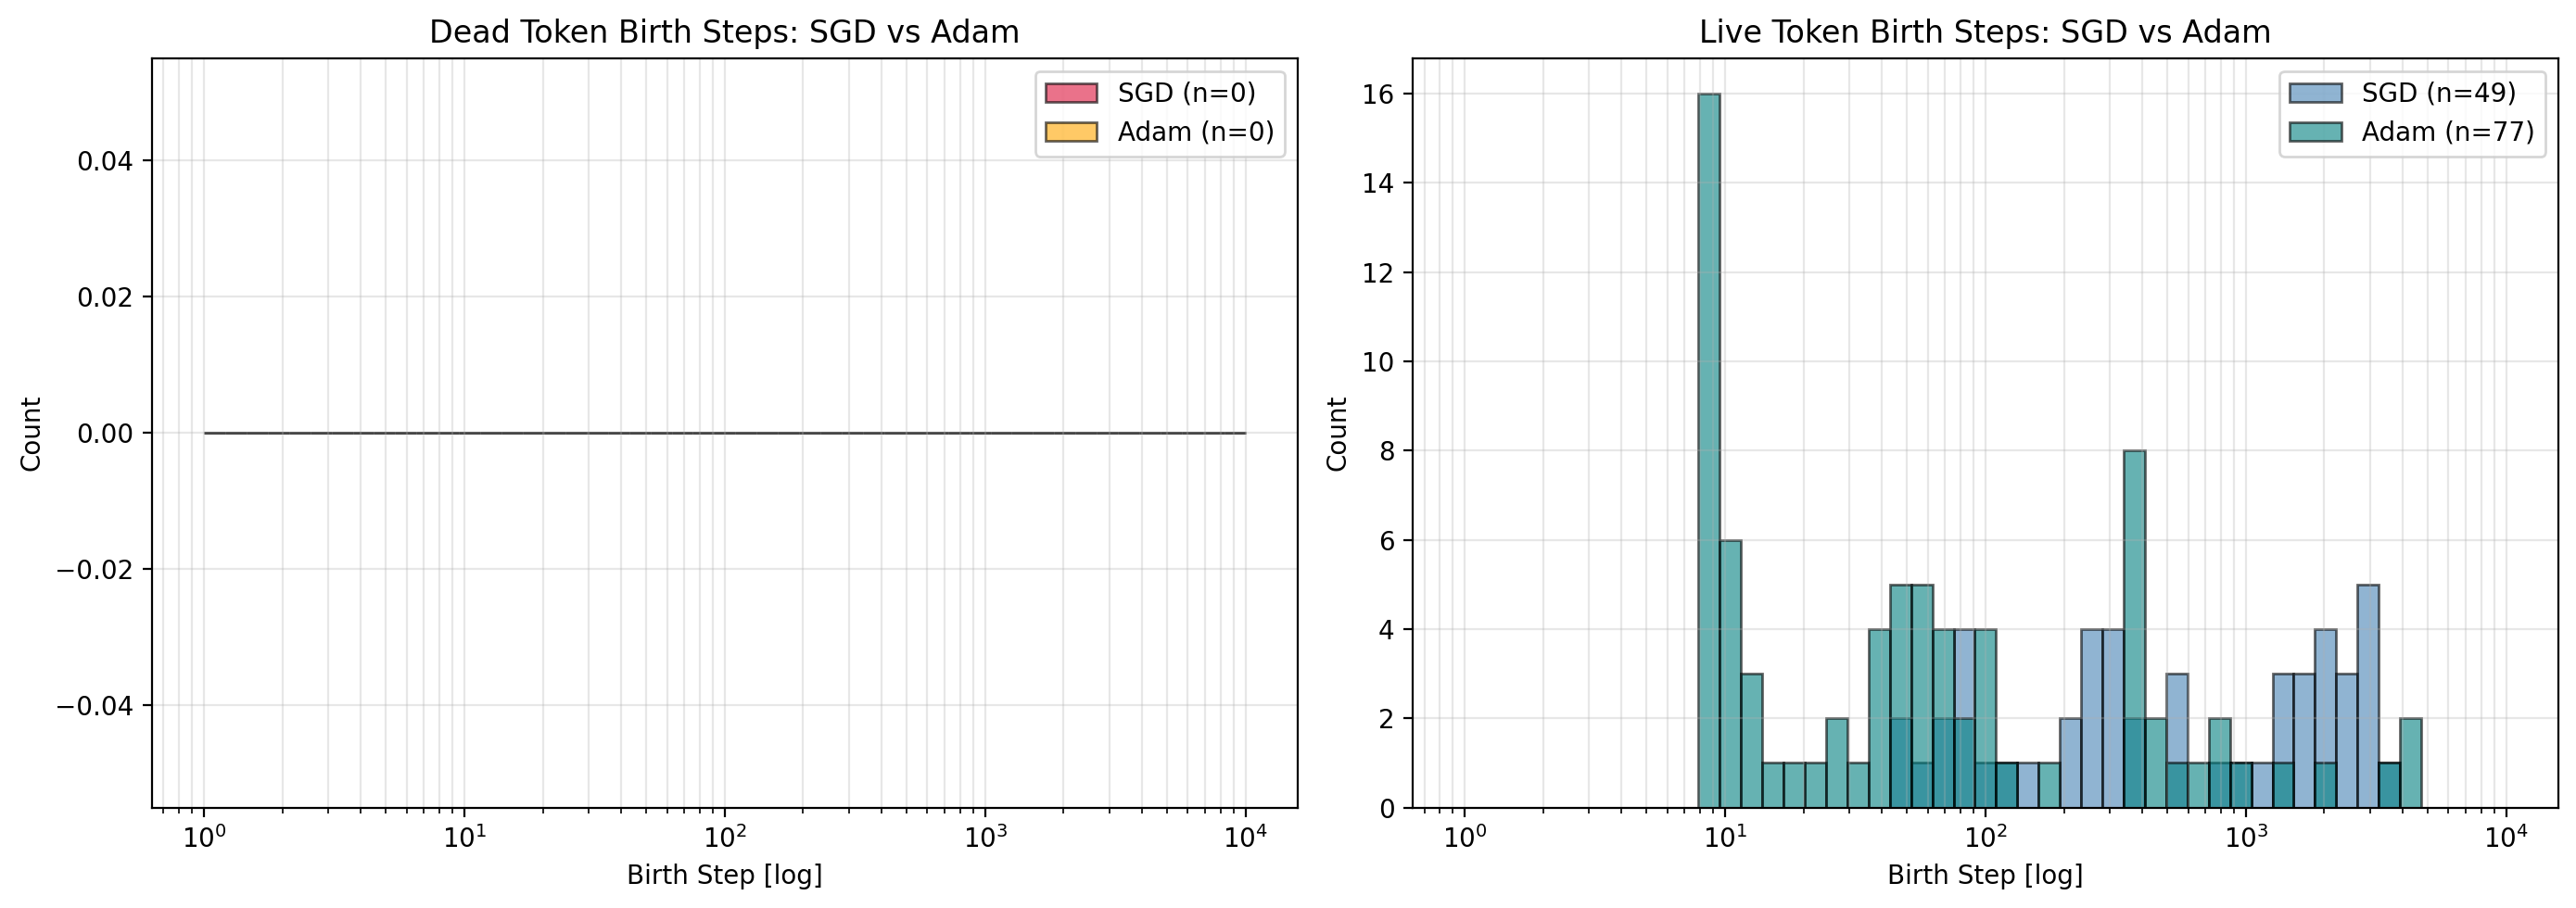

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Dead tokens
sgd_dead_births = sgd_births[sgd_dead.numpy()]
adam_dead_births = adam_births[adam_dead.numpy()]

sgd_dead_valid = sgd_dead_births[sgd_dead_births >= 0]
adam_dead_valid = adam_dead_births[adam_dead_births >= 0]

bins = np.logspace(0, 4, 50)
ax1.hist(sgd_dead_valid, bins=bins, alpha=0.6, color='crimson', 
        label=f'SGD (n={len(sgd_dead_valid)})', edgecolor='black')
ax1.hist(adam_dead_valid, bins=bins, alpha=0.6, color='orange', 
        label=f'Adam (n={len(adam_dead_valid)})', edgecolor='black')
ax1.set_xlabel('Birth Step [log]')
ax1.set_ylabel('Count')
ax1.set_title('Dead Token Birth Steps: SGD vs Adam')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

# Live tokens
sgd_live_births = sgd_births[sgd_live.numpy()]
adam_live_births = adam_births[adam_live.numpy()]

sgd_live_valid = sgd_live_births[sgd_live_births >= 0]
adam_live_valid = adam_live_births[adam_live_births >= 0]

ax2.hist(sgd_live_valid, bins=bins, alpha=0.6, color='steelblue', 
        label=f'SGD (n={len(sgd_live_valid)})', edgecolor='black')
ax2.hist(adam_live_valid, bins=bins, alpha=0.6, color='teal', 
        label=f'Adam (n={len(adam_live_valid)})', edgecolor='black')
ax2.set_xlabel('Birth Step [log]')
ax2.set_ylabel('Count')
ax2.set_title('Live Token Birth Steps: SGD vs Adam')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## Done

In [11]:
print("✓ Angular distinguishability analysis complete")

✓ Angular distinguishability analysis complete
